# Exercise 4.7

Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes.

One of Jack’s employees at the first location rides a bus home each night and lives near the second location. 

She is happy to shuttle one car to the second location for free. 

Each additional car still costs $2, as do all cars moved in the other direction. 

In addition, Jack has limited parking space at each location. 

If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars are kept there). 

These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

![Jack's car rental problem](ex4.2.png)

In [50]:
from dataclasses import dataclass
from typing_extensions import Self
import numpy as np
import math

import matplotlib.pyplot as plt

## Original Problem

In [51]:
# Create State class
@dataclass
class State:
    cars_loc1: int
    cars_loc2: int
    
    def __hash__(self) -> int:
        return hash((self.cars_loc1, self.cars_loc2))
    
    def __eq__(self, other) -> bool:
        if not isinstance(other, State):
            return False
        return (self.cars_loc1 == other.cars_loc1 and 
                self.cars_loc2 == other.cars_loc2)
    
    def __post_init__(self) -> None:
        assert (0 <= self.cars_loc1 <= 20 and 0 <= self.cars_loc2 <= 20), "Cars at each location must be between 0 and 20"
        
    def move_cars(self, cars_moved_l1_to_l2: int) -> tuple[Self, int]:
        assert (-5 <= cars_moved_l1_to_l2 <= 5), "Actions can only move up to 5 cars"
        assert (cars_moved_l1_to_l2 <= self.cars_loc1 and -cars_moved_l1_to_l2 <= self.cars_loc2), "Cannot move more cars than there are at the location"
        
        reward = -2 * np.abs(cars_moved_l1_to_l2)
        
        return State(
            cars_loc1=self.cars_loc1-cars_moved_l1_to_l2, 
            cars_loc2=self.cars_loc2+cars_moved_l1_to_l2,
            ), reward
    
    @staticmethod
    def poisson_prob(n: int, lambda_: int) -> float:
        return (lambda_**n / math.factorial(n)) * np.exp(-lambda_)

    def rent_car(self, location: int, rented_cars: int) -> tuple[Self, float, int]:
        match location:
            case 1:
                cars_available: int = self.cars_loc1
            case 2:
                cars_available:int = self.cars_loc2
        
        assert 0 <= rented_cars <= cars_available, "Cannot rent more cars than are available"
        
        reward = 10 * rented_cars
        
        match location:
            case 1:
                return State(
                    cars_loc1=self.cars_loc1-rented_cars, 
                    cars_loc2=self.cars_loc2,
                    )
            case 2:
                return State(
                    cars_loc1=self.cars_loc1, 
                    cars_loc2=self.cars_loc2-rented_cars,)
    
    def return_car(self, location: int, returned_cars: int) -> tuple[Self, float]:
        match location:
            case 1:
                cars_available: int = self.cars_loc1
            case 2:
                cars_available:int = self.cars_loc2
        
        assert 20 >= returned_cars + cars_available, "Cannot have than 20 cars in parking lot"
        
        match location:
            case 1:
                return State(
                    cars_loc1=self.cars_loc1+returned_cars, 
                    cars_loc2=self.cars_loc2,)
            case 2:
                return State(
                    cars_loc1=self.cars_loc1, 
                    cars_loc2=self.cars_loc2+returned_cars,)
    
    def get_all_transitions(self, action: int) -> list[tuple[Self, float, int]]:
        """
        Returns list of (next_state, probability, reward) for all possible transitions
        given an action.
        """
        # 1. Move cars overnight
        next_state, move_reward = self.move_cars(action)
        
        transitions = []
        # 2. Iterate over all possible combinations:
        for rentals_loc1 in range(next_state.cars_loc1+1):
            max_returns_loc1 = 20 - (next_state.cars_loc1 - rentals_loc1)
            for returns_loc1 in range(max_returns_loc1 + 1):
                for rentals_loc2 in range(next_state.cars_loc2 + 1):
                    max_returns_loc2 = 20 - (next_state.cars_loc2 - rentals_loc2)
                    for returns_loc2 in range(max_returns_loc2 + 1):
                        if not (returns_loc1 - rentals_loc1 == next_state.cars_loc1 - (self.cars_loc1 - action)):
                            continue
                        elif not (returns_loc2 - rentals_loc2 == next_state.cars_loc2 - (self.cars_loc2 + action)):
                            continue
                        elif not (0 <= rentals_loc1 <= next_state.cars_loc1):
                            continue
                        elif not (0 <= rentals_loc2 <= next_state.cars_loc2):
                            continue
                        elif not (0 <= next_state.cars_loc1 - rentals_loc1 + returns_loc1 <= 20):
                            continue
                        elif not (0 <= next_state.cars_loc2 - rentals_loc2 + returns_loc2 <= 20):
                            continue
                        
                        final_state = State(
                            cars_loc1=next_state.cars_loc1 - rentals_loc1 + returns_loc1,
                            cars_loc2=next_state.cars_loc2 - rentals_loc2 + returns_loc2,)
                        
                        # Check if valid state
                        try:
                            final_state.__post_init__()
                        except ValueError:
                            continue
                            
                        # Calculate probabilities
                        rent_loc1_prob: float = self.poisson_prob(rentals_loc1, 3)
                        return_loc1_prob: float = self.poisson_prob(returns_loc1, 3)
                        rent_loc2_prob: float = self.poisson_prob(rentals_loc2, 4)
                        return_loc2_prob: float = self.poisson_prob(returns_loc2, 2)
                        
                        probability: float = rent_loc1_prob * return_loc1_prob * rent_loc2_prob * return_loc2_prob
                        reward: int = move_reward + 10 * (rentals_loc1 + rentals_loc2)
                        
                        transitions.append((final_state, probability, reward))
                        
        return transitions

In [52]:
# Initialize
def initialize() -> tuple[dict, dict]:
    # Initialize V(s) and pi(s) arbitrarily for all s in S
    V: dict[State, float] = {}
    policy: dict[State, int] = {}
    
    # All possible states
    for cars_loc1 in range(21):
        for cars_loc2 in range(21):
            state = State(cars_loc1, cars_loc2)
            V[state] = 0 # arbitrary
            policy[state] = 0 # don't move cars (arbitrary)
    
    return V, policy

In [53]:
# Policy Evaluation
def policy_evaluation(V: dict, policy: dict, theta: float=0.01, gamma: float=0.9) -> tuple[dict, dict]:
    eval_iteration = 0
    while True:
        delta = 0
        # Loop through states
        for state in V:
            v = V[state]
            
            # Get transitions for current policy
            transitions = state.get_all_transitions(policy[state])
            
            # Set new V based on update equation
            V[state] = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in transitions)
            
            # Set Delta
            delta = max(delta, np.abs(v - V[state]))
        
        eval_iteration += 1
        print(f"Policy Evaluation iteration {eval_iteration}, delta: {delta}")
        
        # Check if Delta less than theta
        if delta < theta:
            break
        
    return V, policy

In [54]:
# Policy Improvement
def policy_improvement(V: dict, policy: dict, gamma: float=0.9) -> tuple[dict, dict, bool]:
    policy_stable = True
    action_changes = 0
    
    # Loop through states
    for state in V:
        # Set old action
        old_action = policy[state]
        
        # Calculate value under current policy
        old_transitions = state.get_all_transitions(old_action)
        current_value = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in old_transitions)
        
        # Find best action
        best_value = float('-inf')
        best_action = old_action
        
        for action in range(-5, 6):
            try:
                # Get all transitions for this action
                transitions = state.get_all_transitions(action)
            except AssertionError:
                # Skip invalid actions
                continue
            
                            
            # Calculate value of the action
            action_value = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in transitions)
            
            # Update if value is better
            if action_value > best_value:
                best_value = action_value
                best_action = action
            
        # Update policy if there is a better action
        if best_value > current_value:
            policy[state] = best_action
            if old_action != best_action:
                action_changes += 1
                policy_stable = False
    
    print(f"Number of policy changes: {action_changes}")
    return V, policy, policy_stable

In [55]:
# Policy Iteration Loop
def policy_iteration(theta: float=0.01, gamma: float=0.9) -> tuple[dict, dict]:
    # 1. Initialization
    V, policy = initialize()
    iteration = 0
    
    while True:
        iteration += 1
        print(f"Iteration {iteration}")
        
        # 2. Policy Evaluation
        print(f"Policy Evaluation...")
        V, policy = policy_evaluation(V, policy, theta, gamma)
        
        # 3. Policy Improvement
        print(f"Policy Improvement...")
        V, policy, policy_stable = policy_improvement(V, policy, gamma)
        
        if policy_stable:
            print(f'Policy is stable!')
            break
        
    return V, policy

In [64]:
def visualize_value_policy(V, policy):
    # Create meshgrid of states
    X, Y = np.meshgrid(range(21), range(21))
    values = np.zeros((21, 21))
    actions = np.zeros((21, 21))
    
    for i in range(21):
        for j in range(21):
            state = State(i, j)
            values[i,j] = V[state]
            actions[i,j] = policy[state]
    
    # Plot values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.imshow(values, origin='lower')
    plt.colorbar(label='Value')
    plt.title('State Values')
    plt.xlabel('Cars at Location 1')
    plt.ylabel('Cars at Location 2')
    plt.xticks(range(0, 21, 5))
    plt.yticks(range(0, 21, 5))
    
    # Plot policy
    plt.subplot(122)
    plt.imshow(actions, origin='lower')
    plt.colorbar(label='Action')
    plt.title('Policy (cars to move)')
    plt.xlabel('Cars at Location 1')
    plt.ylabel('Cars at Location 2')
    plt.xticks(range(0, 21, 5))
    plt.yticks(range(0, 21, 5))
    
    plt.tight_layout()
    plt.show()

In [60]:
V, policy = policy_iteration(theta=0.0001)

Iteration 1
Policy Evaluation...
Policy Evaluation iteration 1, delta: 1.0777064448869387
Policy Evaluation iteration 2, delta: 0.01971702516187368
Policy Evaluation iteration 3, delta: 0.00036073003281900107
Policy Evaluation iteration 4, delta: 6.599685070884931e-06
Policy Improvement...
Number of policy changes: 173
Iteration 2
Policy Evaluation...
Policy Evaluation iteration 1, delta: 0.8629353487030833
Policy Evaluation iteration 2, delta: 2.782178167992644e-05
Policy Improvement...
Number of policy changes: 0
Policy is stable!


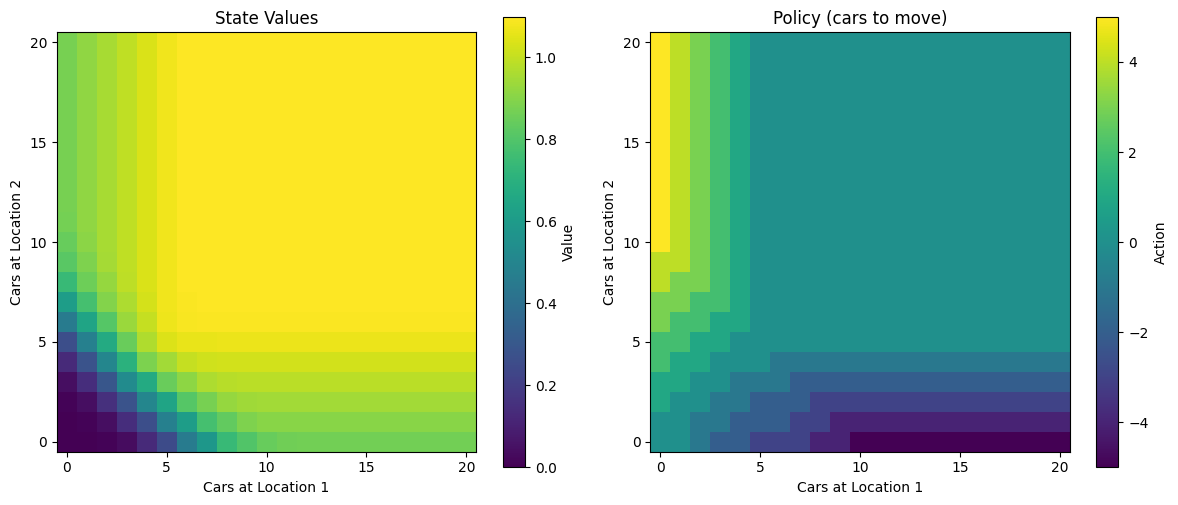

In [65]:
visualize_value_policy(V, policy)